In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import json
import numpy as np
import pandas as pd
from collections import Counter
# Plot Images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
plt.style.use('ggplot')
import matplotlib
# Set GPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# Plotly 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
cd ..

/home/albert/aip-eval


In [19]:
from studio.evaluation.keras import metrics, utils, visualizer, metrics_utils
from studio.evaluation.keras.evaluators import CNNEvaluator

In [4]:
# Models path
model_path_141 = '/home/albert/models_trained/2020_04_27_13-31-26_Albert_141_way_xception_gpus_4_bs_128_smooth_1.07_lr_0.005_50_epochs_default_prep/train/xception_50_epochs/iter_0/model_max_acc_1_gpu.hdf5'
model_path_rev = '/home/albert/models_trained/2020_04_28_09-56-22_Albert_141_way_xception_gpus_4_bs_128_smooth_1.07_lr_0.005_60_epochs_default_prep_reviews_ancestors/train/xception_60_epochs/iter_0/model_max_acc_1_gpu.hdf5'
model_path_141_train_ancest_reviews = '/home/albert/models_trained/2020_05_02_11-10-59_Albert_141_way_xception_gpus_4_bs_128_smooth_1.07_lr_0.005_80_epochs_default_prep_all_train_reviews_ancestors/train/xception_80_epochs/iter_0/model_max_acc_1_gpu.hdf5'
model_path_141_train_ancest_reviews_2 = '/home/albert/models_trained/2020_05_03_11-36-53_Albert_141_way_xception_gpus_4_bs_128_smooth_1.06_lr_0.005_80_epochs_default_prep_all_train_reviews_ancestors_2_rc_85/train/xception_80_epochs/iter_0/model_max_acc_1_gpu.hdf5'

In [5]:
# Data directories
df_100_avg_derm = '/data/datasets/macroscopic/100_benchmarking/manifest_with_avg_derm_141_labels.json'
df_100_juthika = '/data/datasets/macroscopic/100_benchmarking/manifest_with_juthika_141_labels.json'
df_test_path = '/data/datasets/macroscopic/141_way_april_2020/internal_test_set_processed.json'

### Data Preparation

In [6]:
avg_derm_df = pd.read_json(df_100_avg_derm)

In [7]:
ground_truth_probs = np.array(avg_derm_df['class_probabilities'].tolist())

### Evaluation

In [8]:
model_map_path = '/data/datasets/macroscopic/141_way_april_2020/141_way_diagnosis_df.json'
model_map_df = pd.read_json(model_map_path)
concepts_list = [{'id': row['diagnosis_id'] , 'label': row['diagnosis_name']} for i, row in model_map_df.iterrows()]

In [9]:
evaluator = CNNEvaluator(
        concepts=concepts_list,
        model_path=model_path_141,
        batch_size=32,
        verbose=1
        )

/home/albert/aip-eval/.venv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



In [10]:
results = evaluator.evaluate(data_dir='',
                             custom_crop=True,
                             dataframe_path=df_100_avg_derm, 
                             confusion_matrix=False, 
                             top_k=10)

Making predictions from model  0
Found 100 non-validated image filenames belonging to 141 classes.
Input image size:  [299, 299, 3]
4/4 [==============================] - 17s 4s/step


In [11]:
visual_predictions = evaluator.probabilities

### Evaluation of differential labels

In [13]:
ndcgs = metrics.differential_quality_scores(visual_predictions,
                                            ground_truth_probs,
                                            ranked=True,
                                            top_x=5,
                                            top_y=5,
                                            min_probability=0.05)

In [22]:
references_scores, references_indices, hypothesis = metrics_utils.create_ndcg_inputs(visual_predictions,
                                                                       ground_truth_probs,
                                                                       ranked=True,
                                                                       top_x=5,
                                                                       top_y=5,
                                                                       min_probability=0.05)

In [23]:
print('Mean Normalized Discount gain: ', round(np.mean(ndcgs), 4))

Mean Normalized Discount gain:  0.6144


In [24]:
sorted_ndcgs = np.argsort(ndcgs)
sorted_cnn_indices = np.argsort(visual_predictions, axis=1)[:, ::-1]

In [36]:
def plot_ndcg_case(index,
                   evaluator,
                   visual_predictions,
                   sorted_cnn_indices, 
                   references_indices, 
                   references_scores, 
                   concepts_list):
    print('Normalized discounted cumulative gain: ', ndcgs[index])
    print('Predicted: ')

    for i, indice in enumerate(sorted_cnn_indices[index]):
        if i > 4:
            break
        print('Disease: %s | Probability %f ' % (concepts_list[indice]['label'], visual_predictions[index, indice]))

    print('Ground Truth: ')
    for indice, reference_score in zip(references_indices[index], references_scores[index]): 
        if indice != -1:
            print('Disease: %s | Probability %f ' % (concepts_list[indice]['label'], reference_score))

    evaluator.plot_images([evaluator.image_paths[index]])

### Cases with bad NDCG

Normalized discounted cumulative gain:  0.0
Predicted: 
Disease: friction blisters | Probability 0.984380 
Disease: dyshidrotic eczema | Probability 0.009936 
Disease: unspecified dermatitis | Probability 0.002057 
Disease: vitiligo | Probability 0.000969 
Disease: desquamation | Probability 0.000947 
Ground Truth: 
Disease: chronic plaque psoriasis | Probability 0.425926 
Disease: nummular dermatitis | Probability 0.185185 
Disease: pustular psoriasis | Probability 0.129630 
Disease: nail psoriasis | Probability 0.129630 
Disease: palmoplantar-psoriasis | Probability 0.129630 


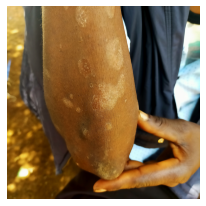

In [37]:
index = sorted_ndcgs[0]
plot_ndcg_case(index,
              evaluator,
              visual_predictions,
              sorted_cnn_indices,
              references_indices,
              references_scores,
              concepts_list)


### Cases with good NDCG

Normalized discounted cumulative gain:  1.0
Predicted: 
Disease: lichen planus | Probability 0.999016 
Disease: prurigo nodularis | Probability 0.000964 
Disease: chronic plaque psoriasis | Probability 0.000010 
Disease: lichen simplex chronicus | Probability 0.000002 
Disease: unspecified dermatitis | Probability 0.000002 
Ground Truth: 
Disease: lichen planus | Probability 1.000000 


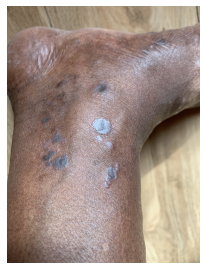

In [38]:
index = sorted_ndcgs[-1]
plot_ndcg_case(index,
              evaluator,
              visual_predictions,
              sorted_cnn_indices,
              references_indices,
              references_scores,
              concepts_list)
